### Solving ODE (damped oscillator)

Problem for $y:[0,10] \rightarrow \mathbb{R}$:
$$
    \begin{cases}
        y'' + \beta y' + \gamma y = 0 \\
        y(0) = 0 \\
        y'(0) = C
    \end{cases}.
$$

Exact solution (assuming $\beta^2 < 4\gamma$):
$$
    y(x) = \frac{2C}{\sqrt{4\gamma-\beta^2}}\sin\left(\frac{x}{2}\sqrt{4\gamma - \beta^2}\right)e^{-\frac{\beta x}{2}}.
$$

In [1]:
import torch
import NURBS_PyTorch_2 as NP2

from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
from math import sqrt

beta  = 1
gamma = 10
C     = 10
sq    = sqrt(4*gamma - beta**2)

def sol(x):
    return 2*C*torch.sin(x*sq/2)*torch.exp(-beta*x/2)/sq

In [3]:
n_control_points = 50
sol_approx       = NP2.Curve_2D(n_control_points = n_control_points) # TODO: Get number of control points from knot vector / basis function set


kv   = NP2.Knot_vector.make_open(n_control_points = n_control_points,
                                 param_max = 10, degree = 4)
bf   = NP2.Basis_functions(kv)
    
sol_approx.set_parameters(
                 basis_function_sets      = [bf],
                 control_point_coord_sets = [NP2.Marsden(kv), # *
                                             torch.rand(sol_approx.control_net_shape)])

print(sol_approx)

# *: Marsden's identity is used to create the identity mapping u -> x. Evaluating this mapping is however suppressed in
# in the following computations since it is unnecessary to do so. Therefore it would be cleaner to not have this as an output
# as of the NURBS object at all.

curve_2D(
	n_inputs = 1,
	n_outputs = 2,
	include_weights = False,
	control_net_shape = (50,),
	basis_functions (dim 0) = basis_functions(
		degree = 4,
		knot_vector = knot_vector(
			knots = tensor([ 0.0000,  0.2174,  0.4348,  0.6522,  0.8696,  1.0870,  1.3043,  1.5217,
			         1.7391,  1.9565,  2.1739,  2.3913,  2.6087,  2.8261,  3.0435,  3.2609,
			         3.4783,  3.6957,  3.9130,  4.1304,  4.3478,  4.5652,  4.7826,  5.0000,
			         5.2174,  5.4348,  5.6522,  5.8696,  6.0870,  6.3043,  6.5217,  6.7391,
			         6.9565,  7.1739,  7.3913,  7.6087,  7.8261,  8.0435,  8.2609,  8.4783,
			         8.6957,  8.9130,  9.1304,  9.3478,  9.5652,  9.7826, 10.0000],
			       device='cuda:0'),
			multiplicities = tensor([5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
			        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5],
			       device='cuda:0', dtype=torch.int32),
			open = True,
			equispaced = True
		)
	)
)


In [4]:
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib notebook

class trainer():
    
    def __init__(self,
                 curve,
                 depth           = 5,
                 n_points_eval   = 1000,
                 learning_rate   = 1e-4,
                 update_interval = 1,
                 dpi             = 100,
                 param_init_r    = 1e-4):
        
        self.device          = curve.device
        self.curve           = curve
        self.n_points_eval   = n_points_eval
        self.update_interval = update_interval
        
        # Width of network
        width = self.curve.control_net_shape[0]
        
        # Layers of MLP network
        layers = [nn.Linear(1,width, device = self.device)] + \
                 [nn.Linear(width,width, device = self.device) for i in range(depth-1)]
        
        # Inialise weights and biases close to 0
        for layer in layers:
            layer.weight.data[:] = (2*torch.rand(layer.weight.data.shape)-1)*param_init_r
            layer.bias.data[:]   = (2*torch.rand(layer.bias.data.shape)-1)  *param_init_r
            
        layers_with_activation = sum([[layer,nn.Tanh()] for layer in layers], [])[:-1]
        
        self.network   = nn.Sequential(*layers_with_activation)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = learning_rate)
        
        self.n_iters_done = 0
        
        self.x_gpu = torch.linspace(0,10,self.n_points_eval, device = self.device)
        self.x_cpu = self.x_gpu.cpu()
        
        self.outputs_include = [1]
        self.update_curve()
        self.curve_eval = self.curve(self.x_gpu, to_memory = "for_training",
                                     derivative_orders = (2,),
                                     outputs_include = self.outputs_include)
        
        # Put boundary basis function values in memory
        zero = torch.zeros(1, device = self.device)
        self.curve(zero, derivative_orders = (1,),
                   to_memory = "boundary")
        
        fig, axs = plt.subplots(2, dpi = 100)
        
        self.fig = fig
        self.axs = axs
        
        self.control_net = axs[0].plot(curve.control_point_coord_sets[0].detach().cpu(),
                                       curve.control_point_coord_sets[1].detach().cpu(),
                                       label = "control net", marker = ".",
                                       color = "r")[0]
        
        self.Bspline_curve = axs[0].plot(self.x_cpu,
                                         self.curve_eval[:,0].detach().cpu(),
                                         color = "C0", label = "B-spline curve")[0]
        
        self.error_curve = axs[1].plot([],[])[0]
        
        axs[1].set_yscale("log")
        axs[1].set_title("Loss")
        
        fig.tight_layout()
        
        self.losses = []
        
    def update_curve(self):
        self.curve.control_point_coord_sets[1] = self.network(torch.ones(1,device = self.device))
        
    def iterate(self):
        
        self.optimizer.zero_grad()
        self.update_curve()
        loss = self.loss()
        loss.backward()
        self.optimizer.step()
        
        self.n_iters_done += 1
        self.losses.append(loss.item())
        
    def loss(self):
        
        knots = self.curve.basis_function_sets[0].knot_vector.knots      
        self.curve_eval = self.curve(from_memory = "for_training",
                                     derivative_orders = (2,),
                                     outputs_include = self.outputs_include)
        y   = self.curve_eval[:,0]
        yd  = self.curve_eval[:,1]
        ydd = self.curve_eval[:,2]

        bdry = sol_approx(from_memory       = "boundary", 
                          derivative_orders = [1], 
                          outputs_include   = self.outputs_include)
        
        y0  = bdry[0]
        yd0 = bdry[1]

        loss  = (ydd + beta*yd + gamma*y).square().mean() # ODE
        loss += y0.square() + (yd0-C).square()            # BCS
        
        return loss
    
    
    def update_fig(self):
        
        self.error_curve.set_data(range(self.n_iters_done),
                                  self.losses)
        
        self.axs[1].set_xlim(0,self.n_iters_done-1)
        self.axs[1].set_ylim(min(self.losses),
                             max(self.losses))
        
        self.control_net.set_data(self.curve.control_point_coord_sets[0].detach().cpu(),
                                  self.curve.control_point_coord_sets[1].detach().cpu())
        
        self.Bspline_curve.set_data(self.x_cpu,
                                    self.curve_eval[:,0].detach().cpu())
        
        self.fig.canvas.draw()
    
    
    
    def train(self,
              eps     = 1e-2,
              maxiter = 2500):
        
        for i in tqdm(range(maxiter)):
            self.iterate()
            
            if self.n_iters_done % self.update_interval == 0:
                self.update_fig()
            
            if self.losses[-1] < eps:
                print("Converged")
                break
            

<IPython.core.display.Javascript object>


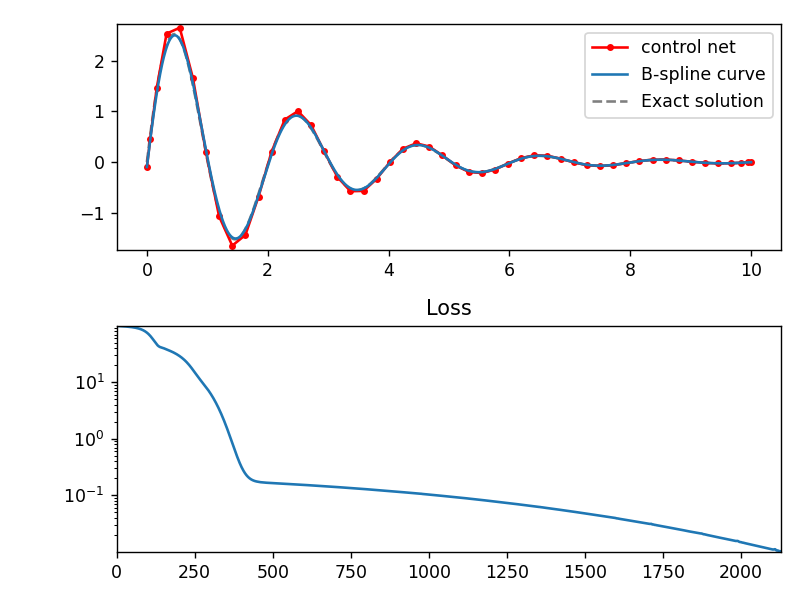

In [5]:
T = trainer(sol_approx, update_interval = 10) 

x = torch.linspace(0,10,1000)
y = sol(x)

T.axs[0].plot(x,y, color = "k", ls = "--", alpha = 0.5, zorder = -1,
              label = "Exact solution")
T.axs[0].legend();

In [6]:
T.train()

  0%|          | 0/2500 [00:00<?, ?it/s]

Converged


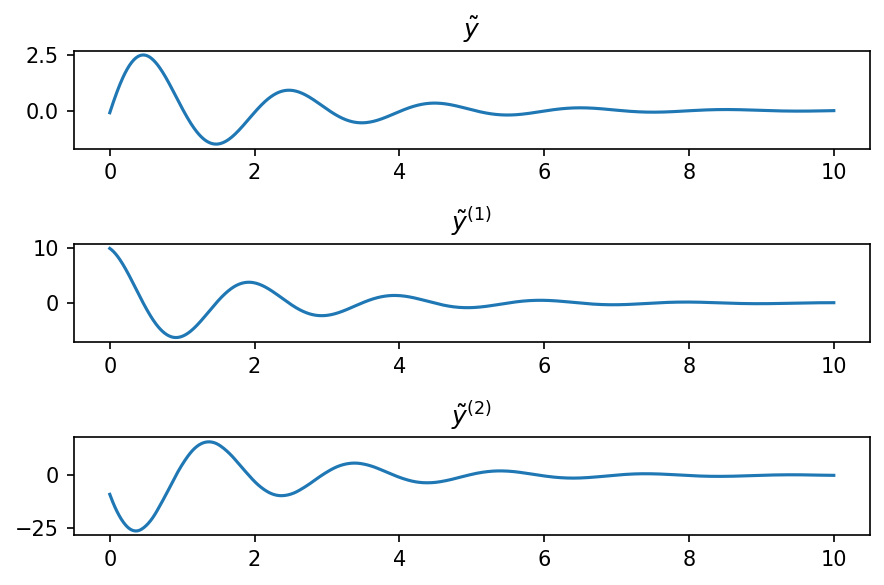

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt

fig,axs = plt.subplots(3, dpi = 150)

Eval = T.curve_eval.detach().cpu()

axs[0].plot(x, Eval[:,0])
axs[1].plot(x, Eval[:,1])
axs[2].plot(x, Eval[:,2])

axs[0].set_title(r"$\tilde{y}$")
axs[1].set_title(r"$\tilde{y}^{(1)}$")
axs[2].set_title(r"$\tilde{y}^{(2)}$")

fig.tight_layout()